# Touch Detection Prototyping

## Goals and Requirements

### Input

The raw touch input is provided as capacitive heatmap.
The resolution of this heatmap is significantly lower than the resolution of the actual screen, which in turn may be lower than the final resolution in which the processed touch point descriptions should be provided.
The input is likely noisy, thus additional precautions may be necessary.

### Output

This project is mainly intended to provide a robust algorithm for use in a Linux kernel module.
In the Linux kernel, touch points can be described via an ellipse representing the contact point (see https://www.kernel.org/doc/html/latest/input/multi-touch-protocol.html for details).
Note: We will for now neglect the appropriate scaling of coordinates to output dimensions.
Thus the provided output for some touch point $i$ is $t_i = (c_i, \theta_i, h_i, w_i)$ with

- $c_i \in \mathbb{R}^{2}$ as the center of the contact point,
- $h_i \in \mathbb{R}$ as the height of the ellipse, i.e. its size along its major axis,
- $w_i \in \mathbb{R}$ as the width of the ellipse, i.e. its size along its minor axis (note that the axes are orthogonal), and
- $\theta_i \in [0,2\pi]$ as the angle of the major axis of the ellipse.

In addition, proper handling of touch points requires tracking of the contact points across consecutive input data frames.
This can be seen as a separate problem ontop of the contact point identification and will be discussed later.
Similarly, handling of noise can be discussed as a separate problem applied to the output data.

## First Approach: A Simplified Setting

Let us for now assume that we only have a single point of contact.
Considering that we need to model the contact point as an ellipse, a two-dimensional Gaussian $\mathcal{N}(x \mid \mu, \Sigma)$ seems like a good choice to start: The mean $\mu \in \mathbb{R}^2$ of the Gaussian directly provides us with the center of the contact point while a confidence bound derived from the covariance matrix $\Sigma \in \mathbb{R}^{2 \times 2}$ provides us with the shape of the ellipse.
This also allows for a neat probabilistic interpretation: $\mathcal{N}(x \mid \mu, \Sigma)$ represents the probability of $x \in \mathbb{R}^2$ being the center of the contact area.

Estimation of the Gaussian is fairly straightforward.
Note that we, however, do not deal with uniformly weighted random samples but instead with a grid, where points have associated values derived from the capacity data of the touchscreen, determining their sample weights.
This suggests modifying the classical maximum likelihood estimators (MLE), yielding

\begin{align*}
    \mathbb{E}[\mu] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot x_i \\
    \mathbb{E}[\Sigma] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot \left(x - \mu\right)
        \left(x - \mu\right)^\intercal
\end{align*}

where $S$ is the set of samples $x_i \in \mathbb{R}^2$ associated with normalized sample weights $y_i \in \mathbb{R}$, such that $\sum_i y_i = 1$ holds.

Let us now apply this.
First we generate some input data for a single contact point, using a Gaussian.
Here we already assume that the input data is pre-processed sufficiently and has normalized values.
We will neglect handling of noise and assume that there are no contact areas intersecting with the boundary.

In [1]:
# imports
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib notebook

In [2]:
# general parameters
input_width, input_height = 0x48, 0x30

In [3]:
def cov(angle, width, height):
    """Generate a 2D covariance matrix from the given confidence bound shape"""
    e1 = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) @ np.array([1.0, 0.0])
    e2 = np.array([[0.0, -1.0], [1.0, 0.0]]) @ e1
    return height * np.outer(e1, e1) + width * np.outer(e2, e2)

def generate_input(width, height, params):
    """Generate artificial input data"""
    data = np.zeros(shape=(width, height))

    for mu, sigma in params:
        for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
            data[x1, x2] += multivariate_normal.pdf(np.array([x1, x2]), mu, sigma)

    return data / np.sum(data)

# parameters for data
mu_real = np.array([15.3, 10.6])
sigma_real = cov(np.deg2rad(35), 1.0, 2.0)

# simulate input data
data = generate_input(input_width, input_height, [(mu_real, sigma_real)])

<IPython.core.display.Javascript object>


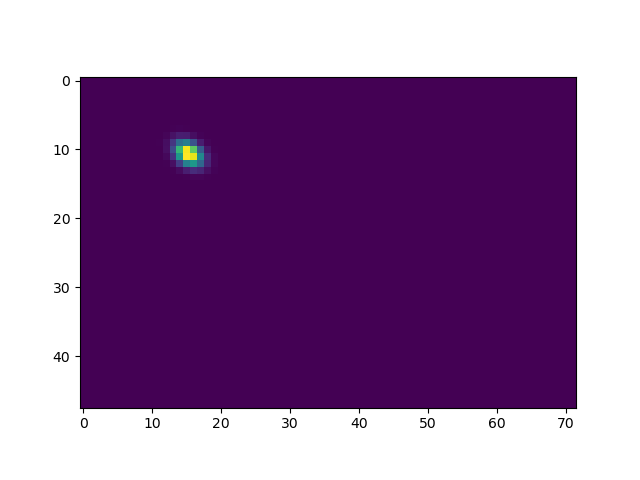

In [4]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plt.show()

Now let's try to reconstruct the parameters for the original Gaussian using the MLEs.
First estimate the mean $\mu$:

In [5]:
def mle_mean(data):
    mu = np.zeros(shape=2)

    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        mu += np.array([x1, x2]) * data[x1, x2]

    return mu

mu = mle_mean(data)

and from that estimate the covariance matrix $\Sigma$:

In [6]:
def mle_cov(data, mu):
    sigma = np.zeros(shape=(2, 2))

    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        d = np.array([x1, x2]) - mu
        sigma += np.outer(d, d) * data[x1, x2]
    
    return sigma

sigma = mle_cov(data, mu)

To see how good this estimate is we can first look at the errors

In [7]:
print(f"error in mu:    {np.linalg.norm(mu_real - mu)}")
print(f"error in sigma: {np.linalg.norm(sigma_real - sigma, ord=np.inf)}")

error in mu:    4.2070441026438876e-11
error in sigma: 6.180222444918115e-10


and then also plot the results:

In [8]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(ax, mu, sigma, nstd, **kwargs):
    """Plot ellipse representing confidence bound with nstd times the standard deviation"""
    eigvals, eigvecs = np.linalg.eigh(sigma)

    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    angle = np.arctan2(vy, vx)

    width, height = 2.0 * nstd * np.sqrt(eigvals)
    ax.add_artist(Ellipse(xy=mu, width=width, height=height, angle=np.degrees(angle), **kwargs))

def plot_mean(ax, mu, **kwargs):
    """Plot mean as cross"""
    ax.plot([mu[0], mu[0]], [mu[1] - 0.5, mu[1] + 0.5], **kwargs)
    ax.plot([mu[0] - 0.5, mu[0] + 0.5], [mu[1], mu[1]], **kwargs)

def plot_gaussian(ax, mu, sigma, nstd, color):
    """Plot Gaussian with confidence bound"""
    plot_mean(ax, mu, color=color)
    plot_cov_ellipse(ax, mu, sigma, 2.0, facecolor='none', edgecolor=color)
    

<IPython.core.display.Javascript object>


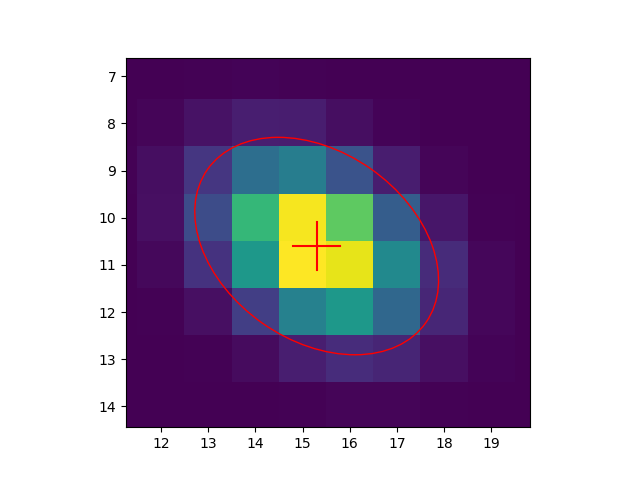

In [9]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')

As we can see, this provides a fairly good reconstruction.
Applied to real data, the estimator of the mean provides sufficiently good resolution and accuracy.
Tuning the `nstd` parameter allows to accurately reconstruct the physical contact area.
Performance, however, is suboptimal as we look at the full heatmap.
This can be improved by first identifying the maximum and then restricting mean and covariance computation to a local area around it.
Furthermore, these estimators break down completely when dealing with multiple touch points:

In [10]:
# generate two contact points
mu1 = np.array([10.0, 20.0])
mu2 = np.array([20.0, 20.0])
sigma = np.identity(2)
data = generate_input(input_width, input_height, [(mu1, sigma), (mu2, sigma)])

# estimate mean and covariance
mu = mle_mean(data)
sigma = mle_cov(data, mu)

<IPython.core.display.Javascript object>


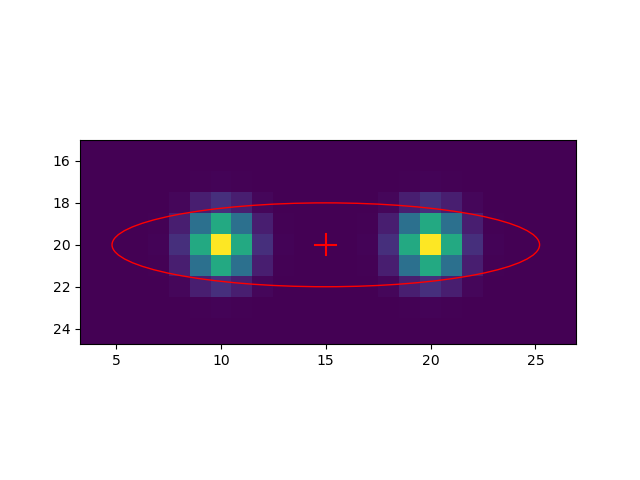

In [11]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')

This is expected, as our current estimators are only designed for reconstructing a single Gaussian.
Next, we will look at how we can extend this approach to multiple Gaussians.

## Extending the Approach to Multiple Contact Points

The basic idea of this is given in Gaussian Mixture Models (GMMs).
While GMMs generally work with random samples and we instead work on a grid with associated weights, the core idea is transferable.

Let us first begin by again creating some artificial input data, this time with two contact areas:

In [12]:
# parameters for data
mu1_real = np.array([15.3, 10.6])
sigma1_real = cov(np.deg2rad(35), 1.0, 2.0)

mu2_real = np.array([35.8, 15.1])
sigma2_real = cov(np.deg2rad(-15), 1.0, 2.0) * 0.3

params_real = [(mu1_real, sigma1_real), (mu2_real, sigma2_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

<IPython.core.display.Javascript object>


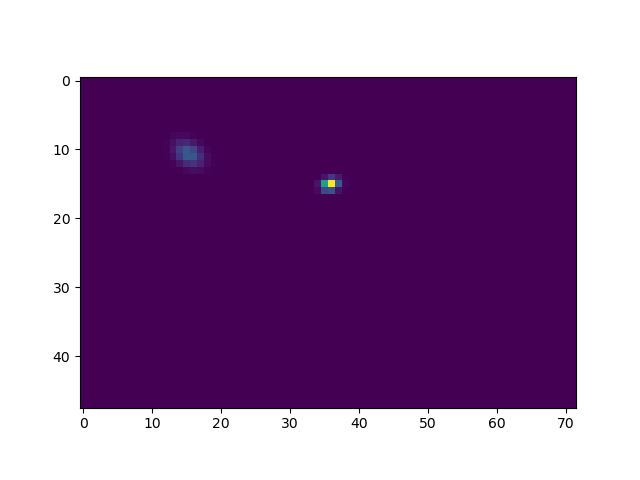

In [13]:
_fig, ax = plt.subplots()
_ = ax.imshow(data.T)

The fundamental idea behind GMMs is an iterative approach:
We start with an initial estimation and then iteratively improve upon this until the changes between iterations are sufficiently small or we've reached the desired accuracy.
So before looking at the acutal algorithm, let's discuss how we get to the initial estimate, first looking at the mean.

In general, we expect contact areas to be centered around a local maximum, which directly leads us to the initial estimate:
Just look for local maximas and assume it is the center of the corresponding contact area.
This also directly gives us the number of contact areas.
Note that we still want to improve upon this first estimate as it is limited to the sensor resolution.

Looking for local maximas is straightforward, we just compare the value each node to the ones of its neighbors.
To make it a bit more robust (and handle borders, where we set the value of the neighbor to zero) we also add a threshold, meaning that the local maxima has to be at least a certain amount over the average (alternatively we could use the minimum).

In [14]:
def get_local_maximas(data, delta=0.01):
    threshold = np.average(data) + delta

    result = []
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        ax1, bx1 = max(x1 - 1, 0), min(x1 + 1, data.shape[0] - 1)
        ax2, bx2 = max(x2 - 1, 0), min(x2 + 1, data.shape[1] - 1)
        
        if data[x1, x2] < threshold:
            continue
        
        area = itertools.product(range(ax1, bx1+1), range(ax2, bx2+1))
        if np.all([(data[x1, x2] >= data[ix1, ix2]) for ix1, ix2 in area]):
            result += [np.array([x1, x2])]
            
    
    return result

maximas = get_local_maximas(data)
maximas

[array([15, 11]), array([36, 15])]

Highlighting the local maximas shows that, while we are limited to the resolution of the sensor, the estimates are fairly good.

<IPython.core.display.Javascript object>


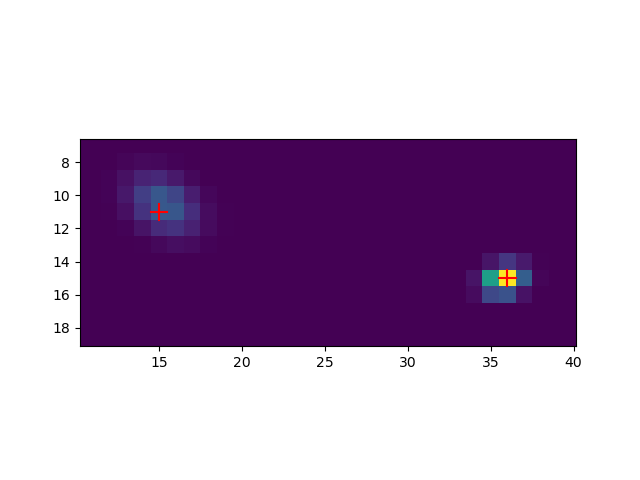

In [15]:
_fig, ax = plt.subplots()
ax.imshow(data.T)

for m in maximas:
    plot_mean(ax, m, color='red')

Now we have the estimates for the means of the Gaussian and we know how many we should try to fit to the data, but we also require estimates for the covariance matrices.
Unfortunately, for those we don't have a good way of estimating them, so we just assume that they are the identity matrix.
In general we would want to scale them a bit to represent the "average" contact area.
Note that the scaled identity as covariance matrix still creates a circular confidence bound, so we don't encode any directional information in our initial guess (i.e. more information than we actually have), which is a good idea.

With that, we have the following initial estimates:

In [16]:
# initial estimate
mu_init = maximas
sigma_init = [np.identity(2), np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

Plotting them shows that they fit fairly well for an initial guess, but of course still require improvement.

<IPython.core.display.Javascript object>


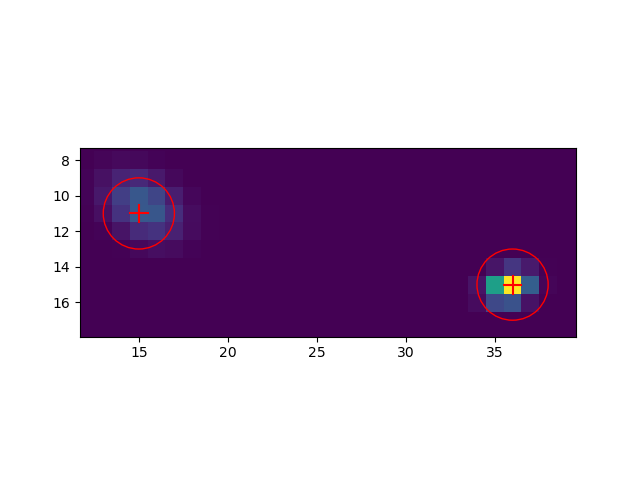

In [17]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
for mu, sigma in params_init:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

With that, we have all the prequisites we need for the actual improvement iterations.

To fully understand the following algorithm let us first look at the classical usage of GMMs for clustering.
In this setting, we have samples $x \in \mathbb{R}^d$ with an associated label $y \in \{1, 2, \ldots, n_{\text{clusters}}\}$ that we want to find.
Note that this is different to our touch detection scenario in that the samples for the clustering scenario do not have to be on a grid, and second, in our scenario we have weights associated with each sample.

A single iteration in GMMs for clustering then consists of two fundamental steps:
1. Use the current estimates to associate each sample with a cluster:
   For each sample $x$ and cluster $c$ compute the probability of the sample belonging to the cluster by evaluating $\mathcal{N}(x \mid \mu_c, \Sigma_c)$, then choose the cluster with the highest probability.
   Here $\mu_c$ and $\Sigma_c$ are the current estimates.
2. Update the estimates based on this association:
   For each cluster, update the estimated mean and covariance matrix using the usual MLE estimators.
   For these estimators, only use the samples that have been associated with the respective cluster in step 1.

This already highlights a fundamental difference between the two scenarios:
In the clustering scenario, we assume that a sample belongs to a single cluster only.
In the contact area detection, however, the sensor values are generally additive blends:
Consider the values of two overlapping contact areas.
At the intersection of those areas, the values of both individual contact Gaussians are added together (or at least we assume them to be).
This in turn means that a sample inside this intersaction is (generally non-equally) shared and we will have to weight it accordingly.
Attributing the full value of such a sample to a single Gaussian will thus skew the estimates.

Let us ignore the issue of overlapping contact areas for now and look at two non-overlapping areas.
For this, we obtain the algorithm below.
Note that we have to take care to normalize our estimates as those are basically weighted averages.

In [18]:
def gmm_iteration(data, params):
    """A single GMM iteration"""
    mu = np.zeros(shape=(len(params), 2))
    sigma = np.zeros(shape=(len(params), 2, 2))
    norm = np.zeros(shape=len(params))

    # compute norms
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        i = np.argmax(y)

        norm[i] += data[x1, x2]

    # estimate means
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        i = np.argmax(y)

        mu[i] += x * data[x1, x2] / norm[i]

    # estimate covariance matrices
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        i = np.argmax(y)

        sigma[i] += np.outer(x - mu[i], x - mu[i]) * data[x1, x2] / norm[i]

    return list(zip(mu, sigma))

def gmm(data, params, n, params_real):
    """Perform n GMM iterations and after each print the current error"""
    for i in range(0, n):
        params = gmm_iteration(data, params)
        
        # compute and display error
        mu, sigma = zip(*params)
        mu_real, sigma_real = zip(*params_real)
        mu, mu_real, sigma, sigma_real = np.array(mu), np.array(mu_real), np.array(sigma), np.array(sigma_real)

        print(f"iteration: {i}")
        print(f"  errors in mu:    {np.linalg.norm(mu_real - mu, axis=1)}")
        print(f"  errors in sigma: {np.linalg.norm(sigma_real - sigma, axis=(1,2), ord=np.inf)}")
    
    return params

With that we can then apply the algorithm to our example and plot the results:

iteration: 0
  errors in mu:    [4.20355302e-11 4.39134374e-03]
  errors in sigma: [6.17711104e-10 1.45549484e-02]
iteration: 1
  errors in mu:    [4.20665003e-11 4.39134374e-03]
  errors in sigma: [6.18022633e-10 1.45549484e-02]
iteration: 2
  errors in mu:    [4.20665003e-11 4.39134374e-03]
  errors in sigma: [6.18022633e-10 1.45549484e-02]


<IPython.core.display.Javascript object>


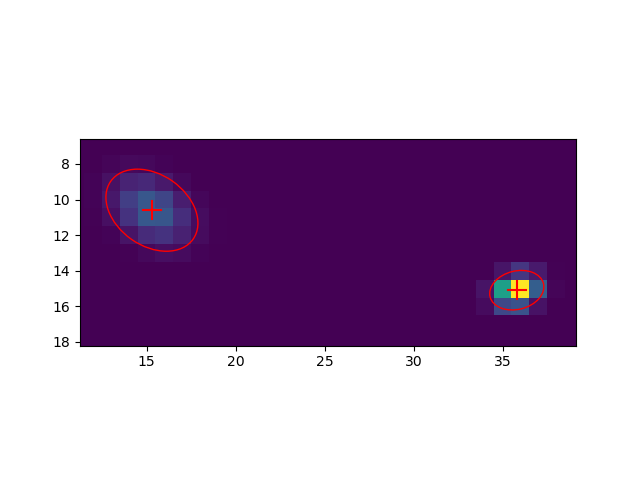

In [19]:
params_est = gmm(data, params_init, 3, params_real)

_fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

As we can see from the error values, even after only a single iteration the results are fairly good.
Further iterations do not improve the estimate, likely due to the close initial estimation.

TODO:
- Evaluate and handle overlapping Gaussians.
- ...